In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from importlib import reload 
import os
from validation import inference_scoring
reload(inference_scoring)
from validation.inference_scoring import model_dirs_to_edge_vectors_list, \
    model_dirs_to_timeseries_vectors, model_dirs_to_boolean_function_vectors, \
    aggregate_classification_metric, model_dirs_to_time_taken_vector
from sklearn.metrics import accuracy_score, roc_auc_score
from matplotlib import pyplot as plt
import numpy as np
import math

In [16]:
reference_dir = os.path.join("..", "data", "generated", "20210329-215102")

In [17]:
inference_results_parent_dir = os.path.join("..", "inferred_models/notebook")
inference_variant_paths = {f.name: os.path.abspath(f.path) for 
                           f in os.scandir(inference_results_parent_dir) if 
                           f.is_dir()}

In [20]:
variants = inference_variant_paths.keys()
# four vectors per variant, since the train-test split is different in each one, so 
# the reference data needs to be split accordingly.
variant_timeseries_vecs = {v: model_dirs_to_timeseries_vectors(reference_dir, p) 
                for v, p in inference_variant_paths.items()}
variant_timeseries_train_scores = {
    n: aggregate_classification_metric(vecs['ref_train'], vecs['pred_train'], accuracy_score) for 
                             n, vecs in variant_timeseries_vecs.items()}
variant_timeseries_test_scores = { 
    n: aggregate_classification_metric(vecs['ref_test'], vecs['pred_test'], accuracy_score) for 
                             n, vecs in variant_timeseries_vecs.items()}

84
84
84
83
83
83


In [21]:
x, y = list(zip(variant_timeseries_vecs['general']['pred_train'],
variant_timeseries_vecs['general']['ref_train']))[2]
print(sum(abs(x-y)))

0.0


In [22]:
variant_timings = {v: model_dirs_to_time_taken_vector(p) 
                for v, p in inference_variant_paths.items()}

In [23]:
variant_edge_vecs = {v: model_dirs_to_edge_vectors_list(reference_dir, p) 
                for v, p in inference_variant_paths.items()}
variant_edge_scores = {
    n: aggregate_classification_metric(vecs['ref'], vecs['pred'], accuracy_score) for 
                             n, vecs in variant_edge_vecs.items()}

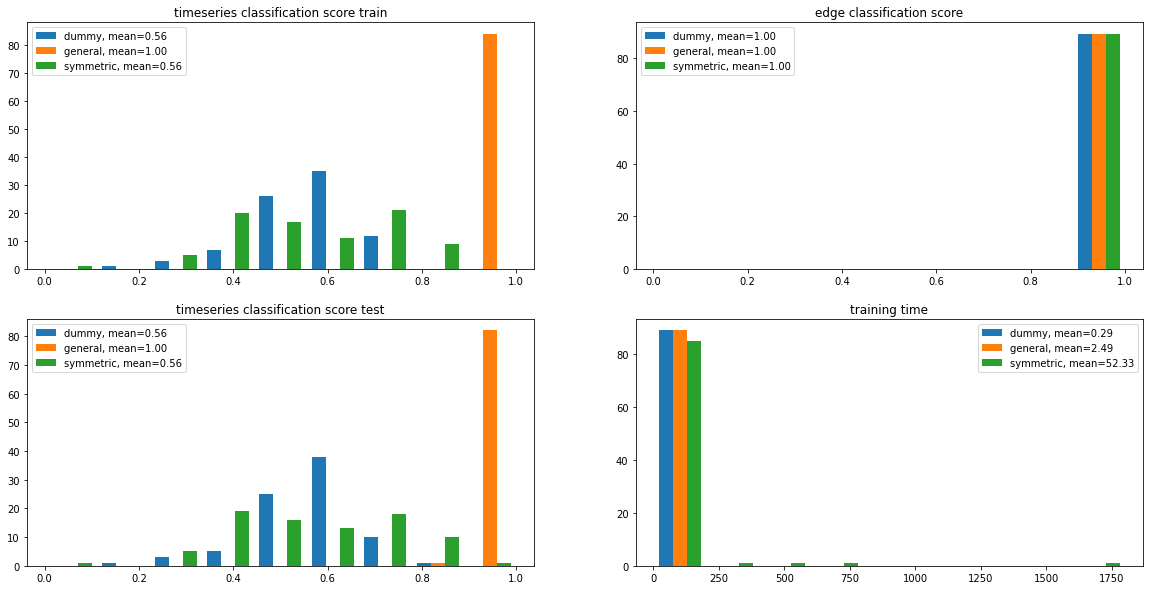

In [25]:
metrics = {'timeseries classification score train': variant_timeseries_train_scores,
           'timeseries classification score test': variant_timeseries_test_scores,
           'edge classification score': variant_edge_scores,
           'training time': variant_timings}

plt.rc('figure', figsize=(20.0, 10.0))
fig, axs = plt.subplots(2, int(math.ceil(len(metrics) / 2)))
for idx, (title, scoring_dict) in enumerate(metrics.items()):
    ax = axs[idx % 2, int(idx / 2)]
    bins = np.linspace(0, 60 * 30 * 1 if 'training time' in title else 1, 10)
    names = []
    hist_vals = []
    for name, scores in scoring_dict.items():
        names.append("{}, mean={:.2f}".format(name, np.mean(scores)))
        hist_vals.append(np.clip(scores, bins[0], bins[-1]))
    ax.hist(hist_vals, label=names, bins=bins)
    ax.legend()
    ax.title.set_text(title)
plt.show()